In [2]:
#Setup
import warnings
import skillsnetwork

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
## Import Keras objects for Deep Learning
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [7]:
# Load in the data set
import pandas as pd

# Use a raw string (r"...") to avoid issues with backslashes
file_path = r"C:\Users\DELL\Desktop\dib_pro\diabetes.csv"

df = pd.read_csv(file_path)

names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin",
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('./diabetes.csv', names=names, header=0)

In [8]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
184,4,141,74,0,0,27.6,0.244,40,0
295,6,151,62,31,120,35.5,0.692,28,0
752,3,108,62,24,0,26.0,0.223,25,0
148,5,147,78,0,0,33.7,0.218,65,0
30,5,109,75,26,0,36.0,0.546,60,0


In [9]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [10]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

In [11]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

In [12]:
pip install shap


   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ------------------- -------------------- 1.3/2.6 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 6.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   - -------------------------------------- 1.3/28.1 MB 6.7 MB/s eta 0:00:04
   -- ------------------------------------- 2.1/28.1 MB 6.9 MB/s eta 0:00:04
   -- ------------------------------------- 2.1/28.1 MB 6.9 MB/s eta 0:00:04
   -- ------------------------------------- 2.1/28.1 MB 6.9 MB/s eta 0:00:04
   -- ------------------------------------- 2.1/28.1 MB 6.9 MB/s eta 0:00:04
   -- ------------------------------------- 2.1/28.1 MB 6.9 MB/s eta 0:00:04
   ----- ---------------------------------- 3.7/28.1 MB 2.4 MB/s eta 0:00:11
   ------- -------------------------------- 5.0/28.1 MB 2.9 MB/s eta 0:00:08
   -------- ------------------------------- 6.3/28.1 MB 3.3 MB/s eta 0:00:07
   ---------- --

In [13]:
### BEGIN SOLUTION
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [14]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)


print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.781
roc-auc is 0.833


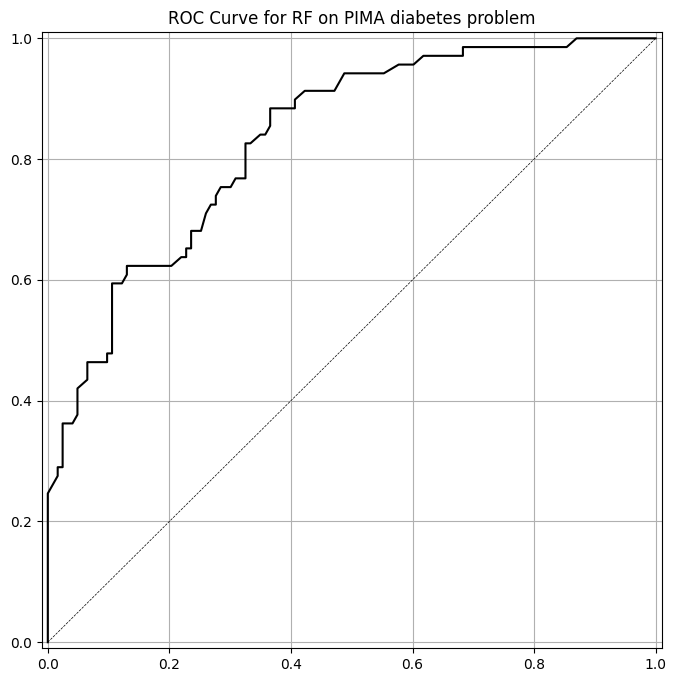

In [15]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')
### END SOLUTION

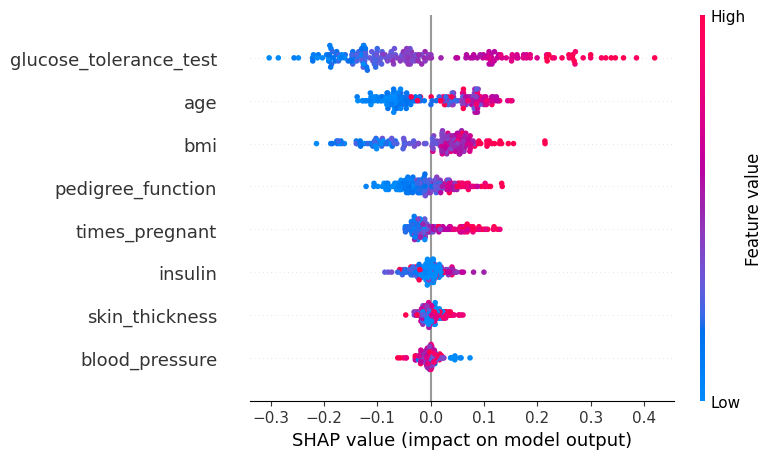

In [16]:
import shap

# Create SHAP explainer (optimized for tree-based models)
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set using the explainer object
shap_values = explainer(X_test)

# === Summary Plot (Global Feature Importance) ===
shap.summary_plot(shap_values.values[:,:,1], X_test, feature_names=names[:-1])

# === Force Plot (Individual prediction) ===
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values.values[0,:,1], X_test[0], feature_names=names[:-1])

In [17]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV with the Random Forest model and parameter grid
grid_search = GridSearchCV(RandomForestClassifier(random_state=11111), param_grid, cv=5, scoring='roc_auc')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best ROC-AUC score
print("Best parameters: ", grid_search.best_params_)
print("Best ROC-AUC score: {:.3f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_rf_model = grid_search.best_estimator_
y_pred_prob_grid = best_rf_model.predict_proba(X_test)[:, 1]
print("Test set ROC-AUC score: {:.3f}".format(roc_auc_score(y_test, y_pred_prob_grid)))

Best parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best ROC-AUC score: 0.842
Test set ROC-AUC score: 0.829


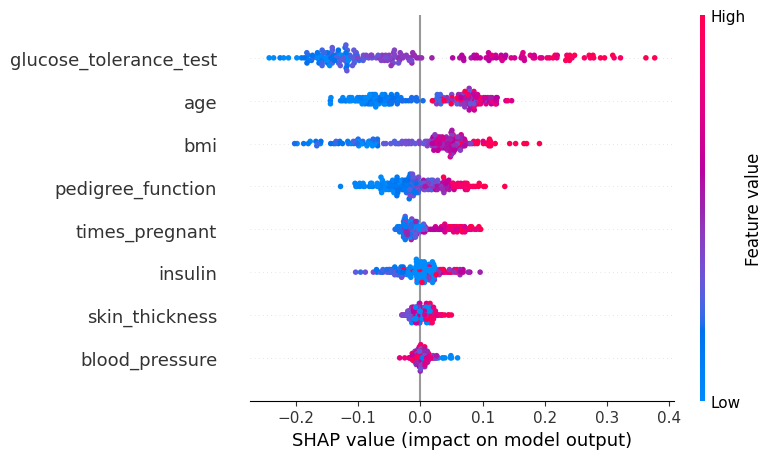

In [19]:
explainer = shap.TreeExplainer(best_rf_model) # Use best_rf_model
shap_values = explainer(X_test) # Use the explainer object to get shap_values

# === Summary Plot (Global Feature Importance) ===
shap.summary_plot(shap_values.values[:,:,1], X_test, feature_names=names[:-1]) # Correct arguments

# === Force Plot (Individual prediction) ===
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values.values[0,:,1], X_test[0], feature_names=names[:-1]) # Correct arguments

# 6. Save Final Model
import pickle

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf_model, f) # Save best_rf_mode

In [20]:
import os
os.listdir()


['.venv',
 'App.py',
 'diabetes.csv',
 'dibetes_project.ipynb',
 'Main.class',
 'rf_model.pkl']